In [1]:
pip install gensim

In [2]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
wv.similarity('great','good')

0.729151

In [6]:
wv.most_similar('home')

[('house', 0.5617802143096924),
 ('Superfast_WiFi', 0.5286994576454163),
 ('homes', 0.5108882188796997),
 ('Home', 0.4817159175872803),
 ('residence', 0.4699970781803131),
 ('bedroom', 0.4698720872402191),
 ('apartment', 0.45603451132774353),
 ('Casa_Del_Lago', 0.4418325424194336),
 ('lakehouse', 0.43524861335754395),
 ('lakefront_cottage', 0.43477556109428406)]

In [9]:
wv.most_similar(positive=['king','women'],negative=['man'])

[('queen', 0.4827326238155365),
 ('queens', 0.466781347990036),
 ('kumaris', 0.4653734564781189),
 ('kings', 0.4558638632297516),
 ('womens', 0.422832190990448),
 ('princes', 0.4176960587501526),
 ('Al_Anqari', 0.41725507378578186),
 ('concubines', 0.4011078476905823),
 ('monarch', 0.3962482810020447),
 ('monarchy', 0.39430150389671326)]

In [10]:
wv.doesnt_match(['facebook','cat','google'])

'cat'

In [11]:
glv = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [16]:
glv.most_similar('harry')

[('niall', 0.9830292463302612),
 ('zayn', 0.9782863259315491),
 ('liam', 0.9777294397354126),
 ('louis', 0.9721062779426575),
 ('justin', 0.9668175578117371),
 ('bieber', 0.9506298899650574),
 ('miley', 0.9479815363883972),
 ('selena', 0.940376877784729),
 ('taylor', 0.9294779300689697),
 ('styles', 0.912164032459259)]

In [17]:
glv.doesnt_match(['facebook','cat','google'])

'cat'

# News Classification Using Gensim Word Vectors

In [18]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

In [19]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", os.listdir(path))
import pandas as pd

df_true = pd.read_csv(f'{path}/True.csv')
df_true['label'] = 'Real'
df_false = pd.read_csv(f'{path}/Fake.csv')
df_false['label'] = 'Fake'

100%|██████████| 41.0M/41.0M [00:00<00:00, 114MB/s]

Extracting files...


Path to dataset files: ['True.csv', 'Fake.csv']


In [35]:
df = pd.concat([df_true,df_false],axis = 0)

In [36]:
df.drop(['title','subject','date'],axis = 1,inplace = True)

In [37]:
df.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,Real
1,WASHINGTON (Reuters) - Transgender people will...,Real
2,WASHINGTON (Reuters) - The special counsel inv...,Real
3,WASHINGTON (Reuters) - Trump campaign adviser ...,Real
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,Real


In [38]:
df.shape

(44898, 2)

In [43]:
df_front = df.head(500)
df_back = df.tail(500)
df_short = pd.concat([df_front,df_back],axis = 0)

In [44]:
df_short.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,Real
1,WASHINGTON (Reuters) - Transgender people will...,Real
2,WASHINGTON (Reuters) - The special counsel inv...,Real
3,WASHINGTON (Reuters) - Trump campaign adviser ...,Real
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,Real


In [45]:
df_short.shape

(1000, 2)

In [46]:
df_short['label'].value_counts()

,count
label,
Real,500
Fake,500


In [51]:
df_short['label_num'] = df_short['label'].map({'Fake':0,
                                   'Real':1})

In [52]:
df_short.head()

,text,label,label_num
0,WASHINGTON (Reuters) - The head of a conservat...,Real,1
1,WASHINGTON (Reuters) - Transgender people will...,Real,1
2,WASHINGTON (Reuters) - The special counsel inv...,Real,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,Real,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,Real,1


In [55]:
! python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [61]:
import spacy
nlp = spacy.load('en_core_web_lg')

def preprocess_and_vectorize(text):
  doc = nlp(text)

  filtered_tokens =[]
  for token in doc:
    if token.is_punct or token.is_stop:
      continue
    filtered_tokens.append(token.lemma_)

  return wv.get_mean_vector(filtered_tokens)

In [65]:
preprocess_and_vectorize("Don't worry if you don't understand").shape

(300,)

In [66]:
wv.get_mean_vector(['worry','understand'])[:5]

array([ 0.00235079, -0.00284596, -0.03638233,  0.00413919, -0.10635224],
      dtype=float32)

In [67]:
df_short['vector']  = df_short['text'].apply(lambda text: preprocess_and_vectorize(text))

# Train Test Splitting

In [68]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_short['vector'],df_short['label_num'],
                                                 test_size=0.2,
                                                 random_state=18,stratify=df_short['label_num'])

In [70]:
# Reshaping the X_train and X_test so as to fit the models
print('Shape of X_train before reshaping:',X_train.shape)
print('Shape of X_test before reshaping:',X_test.shape)


import numpy as np
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

print('Shape of X_train after reshaping:',X_train_2d.shape)
print('Shape of X_test after reshaping:',X_test_2d.shape)

Shape of X_train before reshaping: (800,)
Shape of X_test before reshaping: (200,)
Shape of X_train after reshaping: (800, 300)
Shape of X_test after reshaping: (200, 300)


## Train Machine Learning Model



In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# creatin a GB model object

clf = GradientBoostingClassifier()

#fit with all train embeddings and y_train
clf.fit(X_train_2d,y_train)

#get the predictions for all_test_embedins and store itin y_pred
y_pred = clf.predict(X_test_2d)

#4 print the classificaton repor
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       100
           1       0.94      0.94      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



# Make some Predictions

In [73]:
test_news = ["The Richmond, Virginia-based 4th U.S. Circuit Court of Appeals said the lower-court judge likely lacked the power to hear the lawsuit brought by 19 states and Washington, D.C., to challenge the mass firings of probationary government employees in February.",
             "Probationary employees typically have less than a year of service in their current roles, though some are longtime federal workers in new jobs.",
             'Iron man returns to the Scene with a much wait character']

test_news_vectors = [preprocess_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors)

array([1, 1, 0])

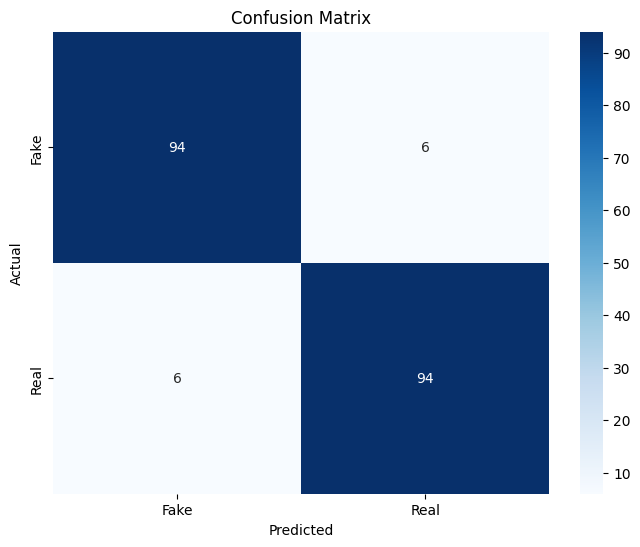

In [75]:
# prompt: help me plot a confusing matric usig matplotlib and seaborjn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are already defined from your previous code

cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# You can also plot the confusion matrix with normalized values
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#plt.figure(figsize=(8, 6))
#sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
#            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.title('Normalized Confusion Matrix')
#plt.show()
